In [24]:
#Imports 
from matplotlib import pyplot as plt
from tqdm import tqdm 
import pandas as pd 

In [25]:
#Read data
flights             = pd.read_csv('Airports2.csv')
flights['Fly_date'] = pd.to_datetime(flights['Fly_date'])
flights['dstate']   = flights['Destination_city'].apply(lambda x: x[-2:])
flights['ostate']   = flights['Origin_city'].apply(lambda x: x[-2:])
flights['month']    = flights['Fly_date'].dt.month
flights['year']     = flights['Fly_date'].dt.year

# Get top airports
all_airports        = pd.concat([flights['Origin_airport'], flights['Destination_airport']])
top_airports        = list(all_airports.value_counts().head(30).index)
top_airports        = list(flights.loc[flights['dstate'].apply(lambda x: x in ['SC', 'VA']), 'Destination_airport'].unique())
# airport_encoding    = {airport:i for i, airport in enumerate(top_airports)}

# Only flights from top airports
flights             = flights[flights.apply(lambda x: (x['Origin_airport'] in top_airports) and (x['Destination_airport'] in top_airports), axis=1)]

# Aggregate (sum) passengers, flights and distance
tmp                 = flights.groupby(['Origin_airport', 'Destination_airport', 'Fly_date'])
sums                = tmp.sum().reset_index()
sums                = sums[sums['Distance'] > 0]

# Filter one year of data
new_flights         = sums[['Origin_airport', 'Destination_airport', 'Fly_date', 'Passengers']]
new_flights         = new_flights.reset_index(drop=True)

# one_year = new_flights[new_flights['Fly_date'].apply(lambda x: x.year in range(1990, 2000))]
one_year            = new_flights[new_flights['Fly_date'].apply(lambda x: x.year == 1990)]
T                   = sorted(one_year['Fly_date'].unique())
date_encoding       = {v:i for i, v in enumerate(T)}
one_year['Fly_date']=one_year['Fly_date'].replace(date_encoding)
one_year['Fly_date']= one_year['Fly_date'] + 1
one_year            = one_year.reset_index(drop=True)
one_year            = one_year[one_year['Passengers'] > 0]

/var/folders/qr/7k537p855t93rbkdcl42hxp80000gn/T/ipykernel_40859/3522385388.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date']=one_year['Fly_date'].replace(date_encoding)
/var/folders/qr/7k537p855t93rbkdcl42hxp80000gn/T/ipykernel_40859/3522385388.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_year['Fly_date']= one_year['Fly_date'] + 1


# MCMC

In [26]:
import random

def mcmc3(n_walks):

    walks = []
    meta = []
    for _ in tqdm(range(n_walks)):

        time_weights    = one_year.groupby('Fly_date').sum()['Passengers']/(one_year['Passengers'].sum())
        time_weights    = time_weights[:-2]
        time_steps      = time_weights.index.values
        rand_start_time = random.choices(time_steps, weights=time_weights.values)[0]
        lengths         = range(1, 14-rand_start_time)
        # rand_length     = random.choices(lengths, weights=lengths[::-1])[0]
        rand_length     = random.choice(lengths)
        # rand_length     = 2
        
        meta.append((rand_start_time, rand_length))
        walk = []
        for i in range(rand_length):
            tmp = one_year[(one_year['Fly_date'] == rand_start_time+i)]
            if i > 0:
                tmp = tmp[tmp['Origin_airport'] == destination]
                if len(tmp) == 0:
                    continue
            flight = tmp.sample(n=1, weights='Passengers')
            destination = flight['Destination_airport'].values[0]
            origin = flight['Origin_airport'].values[0]
            walk.append("%s_%s" % (origin, rand_start_time+i))
        walk.append("%s_%s" % (destination, rand_start_time+i+1))
        # print(walk)
        # print(rand_start_time, rand_length)

        walks.append(walk)

    walks_df = pd.DataFrame(walks)
    meta_df = pd.DataFrame(meta)

    walks_df.to_csv('walks.csv')

mcmc3(1000)

100%|██████████| 1000/1000 [00:04<00:00, 229.35it/s]


## Node Positioning

Create a static adjacency matrix for the graph.


In [27]:
matrix = pd.DataFrame(0, index=top_airports, columns=top_airports)
for i in tqdm(range(len(one_year))):
    row = one_year.iloc[i]
    matrix.loc[row['Origin_airport'], row['Destination_airport']] += row['Passengers']

100%|██████████| 180/180 [00:00<00:00, 5435.93it/s]


In [28]:
#Clustering (static adjacency matrix)

from sklearn.cluster import AgglomerativeClustering, KMeans
# sc = AgglomerativeClustering(n_clusters=3)
sc = KMeans(n_clusters=2, random_state=42)
clusters = sc.fit_predict(matrix)

In [29]:
clusters_series = pd.Series(data=clusters, index=matrix.index).sort_values()
clusters_series.name = 'cluster'

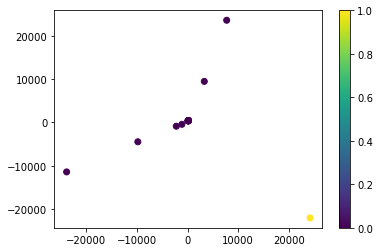

In [30]:
# Dimensionality reduction to 2-dimensional space 
# for visualization of clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(matrix)
reduced = pd.DataFrame(reduced)
plt.scatter(reduced[0], reduced[1], c=clusters);
plt.colorbar();

In [31]:
# # Creating a mapping between airports and clusters

clusters_dict = dict(zip(matrix.index,clusters))
clusters_series = pd.Series(clusters_dict).sort_values()
clusters_series.name = 'cluster'

la_airs = flights.loc[flights['dstate']=='SC', 'Destination_airport'].unique()
co_airs = flights.loc[flights['dstate']=='VA', 'Destination_airport'].unique()

clusters = {air: 0 for air in la_airs}
clusters.update({air: 1 for air in co_airs})
clusters_series = pd.Series(clusters)
clusters_series.name = 'cluster'

In [32]:
# Sorting top airports by their cluster number 

# top_airports.sort(key=lambda x: clusters_series.loc[x])

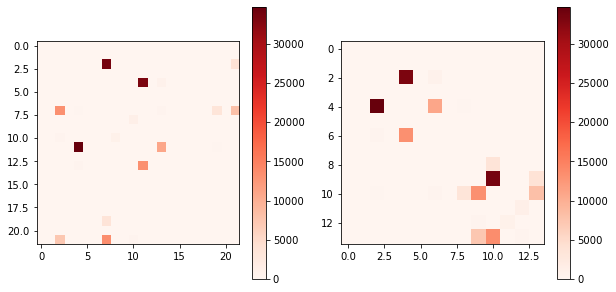

In [33]:
# Visualizing the adjacency matrix before and after sorting by clusters

fig, axs = plt.subplots(1, 2, figsize=(10,5))

img = axs[0].imshow(matrix, cmap='Reds');
fig.colorbar(img, ax=axs[0]);

matrix_2 = matrix.loc[clusters_series.index, clusters_series.index]
img = axs[1].imshow(matrix_2, cmap='Reds');
# axs[1].set_yticks(range(len(matrix_2)), clusters_series.values);
fig.colorbar(img, ax=axs[1]);


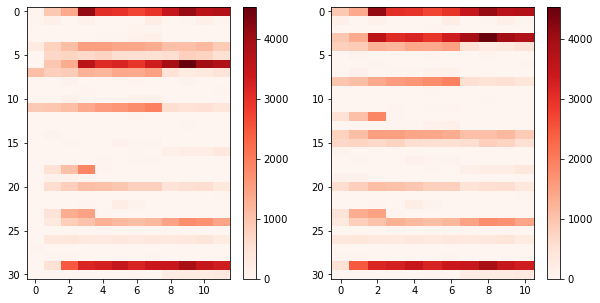

In [34]:
# Visualizing the carpet plot before and after sorting by clusters

carpet = one_year.pivot_table(index=['Origin_airport', 'Destination_airport'], \
    columns='Fly_date', values='Passengers', aggfunc='sum').fillna(0).reset_index()

carpet2 = pd.merge(clusters_series, carpet, right_on='Origin_airport', left_index=True)
carpet2 = carpet2.sort_values(['cluster', 'Origin_airport'])
carpet2.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
img = axs[0].imshow(carpet[carpet.columns[2:]], cmap='Reds', aspect='auto');
fig.colorbar(img, ax=axs[0]);
img = axs[1].imshow(carpet2[carpet.columns[3:]], cmap='Reds', aspect='auto');
# axs[1].set_yticks(carpet2.index[::10], carpet2['cluster'][::10].values);
# axs[1].set_yticks(carpet2.index, carpet2['cluster'].values);
fig.colorbar(img, ax=axs[1]);

## Flights for airport grid

In [35]:
merged  = pd.merge(one_year, clusters_series, left_on='Origin_airport', right_index=True)
merged2 = pd.merge(merged, clusters_series, left_on='Destination_airport', right_index=True, suffixes=('_origin', '_destination'))

In [36]:
cluster_stats = merged2.groupby(['cluster_origin', 'cluster_destination']).apply(\
                    lambda x: pd.Series({'size': x.size, 'sum': x['Passengers'].sum()})).reset_index()

cluster_stats.sort_values(['size'], ascending=False)

,cluster_origin,cluster_destination,size,sum
3,1,1,534,82177
0,0,0,414,93559
2,1,0,84,3974
1,0,1,48,3643


In [37]:
merged2.head()

,Origin_airport,Destination_airport,Fly_date,Passengers,cluster_origin,cluster_destination
0,CAE,CHS,1,55,0,0
1,CAE,CHS,2,929,0,0
2,CAE,CHS,3,1379,0,0
3,CAE,CHS,4,4120,0,0
4,CAE,CHS,5,3033,0,0


In [38]:
merged2.sort_values(['Passengers'], ascending=False).head(10)

,Origin_airport,Destination_airport,Fly_date,Passengers,cluster_origin,cluster_destination
58,CHS,CAE,10,4535,0,0
3,CAE,CHS,4,4120,0,0
9,CAE,CHS,10,4081,0,0
59,CHS,CAE,11,3981,0,0
57,CHS,CAE,9,3924,0,0
177,ROA,RIC,10,3891,1,1
60,CHS,CAE,12,3799,0,0
11,CAE,CHS,12,3757,0,0
10,CAE,CHS,11,3657,0,0
52,CHS,CAE,4,3633,0,0


In [39]:
merged2['color'] = merged2.apply(lambda x: "red" if x['cluster_origin'] == x['cluster_destination'] else "blue", axis=1)
merged2['Origin_airport']      = merged2.apply(lambda x: "%s_%s" % (x['Origin_airport'],      x['Fly_date']), axis=1)
merged2['Destination_airport'] = merged2.apply(lambda x: "%s_%s" % (x['Destination_airport'], x['Fly_date']+1), axis=1)

In [40]:

merged2 = merged2[['Origin_airport', 'Destination_airport', 'Passengers', 'color']]
merged2.columns = ['origin', 'destination', 'count', 'color']
merged2.to_csv('flights.csv', index=False)

## Grid Positioning 

$ (t*c_x, i*c_y)$ where $i \in [0, N]$  and $t \in [0, T]$ such that $N$ is number of nodes (e.g. airports) and $T$ is time (e.g. days). 

$c_x$ and $c_y$ are constants that define the distance distance from origin $(0, 0)$ as well as between other nodes. 

In [41]:
locs = []

# width = 960
# height = 600
time_steps = len(date_encoding)
c_x = time_steps*6
c_y = 40
# for k in airport_encoding:
    # i = airport_encoding[k]
for i, k in enumerate(clusters_series.index):
    for t in range(1, time_steps+2): #list(date_encoding.values()):
        locs.append(["%s_%s" % (k,t), (t+1)*c_x, (i+1)*c_y, clusters_series[k]])
locs_df = pd.DataFrame(locs)


In [42]:

locs_df.columns = ['iata', 'latitude', 'longitude', 'cluster']

cluster_colors = {0: "LightSkyBlue", 1: "LightCoral", 2: "orange", 3: "lightblue"}

locs_df['color'] = locs_df['cluster'].apply(lambda x: cluster_colors[x])

In [43]:
clusters_series.reset_index().groupby('cluster').apply(lambda x: list(x['index'].values))

cluster
0    [SSC, AND, CAE, FLO, CHS, GGE, GSP, GDC, MYR]
1                        [ROA, RIC, SHD, LYH, CHO]
dtype: object

In [44]:
locs_df.columns = ['iata', 'longitude', 'latitude', 'cluster', 'color']

In [45]:


# locs_df['latitude']  = locs_df['latitude']
# locs_df['latitude']  = locs_df['latitude']
locs_df.to_csv('grid_locs.csv', index=False)

In [46]:
# pd.DataFrame(walks)